## Intensity simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from tapqir.models import Cosmos
from tapqir.utils.stats import ci_from_trace
from pyro.infer import Predictive

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
predictions = defaultdict(dict)
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("height"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        model = Cosmos()
        model.load(data_path, True, "cpu")
        model.load_parameters(param_path)
        mask = torch.from_numpy(model.data.labels["z"])
        samples = torch.masked_select(model.z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        predictions[data_path.name]["z_all"] = model.z_marginal.flatten()

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df = truth_df.sort_values(by="height")
truth_df

,width,gain,pi,lamda,proximity,offset,height,background,snr
height300,1.4,7.0,0.15,0.15,0.2,90.0,300.0,150.0,0.375890
height500,1.4,7.0,0.15,0.15,0.2,90.0,500.0,150.0,0.626483
height600,1.4,7.0,0.15,0.15,0.2,90.0,600.0,150.0,0.751780
height750,1.4,7.0,0.15,0.15,0.2,90.0,750.0,150.0,0.939725
height1000,1.4,7.0,0.15,0.15,0.2,90.0,1000.0,150.0,1.252967
height1500,1.4,7.0,0.15,0.15,0.2,90.0,1500.0,150.0,1.879450
height2000,1.4,7.0,0.15,0.15,0.2,90.0,2000.0,150.0,2.505933
height3000,1.4,7.0,0.15,0.15,0.2,90.0,3000.0,150.0,3.758899


In [5]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by="height")
fit_df["marginal"]

height300     True
height500     True
height600     True
height750     True
height1000    True
height1500    True
height2000    True
height3000    True
Name: marginal, dtype: object

In [6]:
fit_df["classifier"]

height300     True
height500     True
height600     True
height750     True
height1000    True
height1500    True
height2000    True
height3000    True
Name: classifier, dtype: object

In [7]:
fit_df = fit_df.drop(columns=["marginal", "classifier"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,Recall,Precision,TN,FP,FN,TP,z_median,z_ll,z_ul,height
height300,1.171844,7.017156,7.017156,7.017156,0.001520,0.001520,0.001520,2.466577e-07,2.466577e-07,2.466577e-07,...,0.011173,1.000000,2142.0,0.0,354.0,4.0,0.000147,0.000040,0.001016,300.0
height500,1.158543,7.036217,7.036217,7.036217,0.025246,0.025246,0.025246,3.926317e-07,3.926317e-07,3.926317e-07,...,0.139665,0.943396,2139.0,3.0,308.0,50.0,0.023742,0.003707,0.393330,500.0
height600,1.088034,7.062657,7.062657,7.062657,0.062252,0.062252,0.062252,1.840548e-03,1.840548e-03,1.840548e-03,...,0.377095,0.950704,2135.0,7.0,223.0,135.0,0.237972,0.026788,0.967549,600.0
height750,1.099096,7.058381,7.058381,7.058381,0.119392,0.119392,0.119392,1.332163e-02,1.332163e-02,1.332163e-02,...,0.776536,0.945578,2126.0,16.0,80.0,278.0,0.955062,0.336406,0.998702,750.0
height1000,1.262311,7.055233,7.055233,7.055233,0.149783,0.149783,0.149783,6.875274e-02,6.875274e-02,6.875274e-02,...,0.988827,0.951613,2124.0,18.0,4.0,354.0,0.997516,0.990176,0.998244,1000.0
height1500,1.868378,7.004901,7.004901,7.004901,0.147590,0.147590,0.147590,1.240443e-01,1.240443e-01,1.240443e-01,...,0.986034,0.969780,2131.0,11.0,5.0,353.0,0.997395,0.996020,0.998023,1500.0
height2000,2.502502,6.991581,6.991581,6.991581,0.144283,0.144283,0.144283,1.339201e-01,1.339201e-01,1.339201e-01,...,0.983240,0.977778,2134.0,8.0,6.0,352.0,0.997631,0.995792,0.998216,2000.0
height3000,3.767562,6.999659,6.999659,6.999659,0.147087,0.147087,0.147087,1.368161e-01,1.368161e-01,1.368161e-01,...,0.977654,0.980392,2135.0,7.0,8.0,350.0,0.997925,0.995820,0.998526,3000.0


In [8]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data1/height.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")

### Figure 2

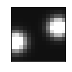

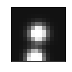

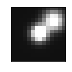

In [9]:
path_data = EXAMLES_DIR / "lamda0.5"
path_params = path_data / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4"

# load parameters
model = Cosmos(S=1, K=2)
model.load(path_data, True, "cpu")
model.load_parameters(path_params)

n = ontarget = 0
frames = [295, 85, 30]

for i, f in enumerate(frames):
    img_ideal = model.data.offset_mean + pyro.param("d/b_loc").data[n, f:f+1, None, None]
    gaussian = model.data_loc(
        pyro.param("d/h_loc").data[:, n, f:f+1].masked_fill(model.m_probs[:, n, f:f+1] < 0.5, 0.),
        pyro.param("d/w_mean").data[:, n, f:f+1],
        pyro.param("d/x_mean").data[:, n, f:f+1],
        pyro.param("d/y_mean").data[:, n, f:f+1],
        n, torch.arange(f,f+1)
    )
    img_ideal = img_ideal + gaussian.sum(-4)
    
    plt.figure(figsize=(1., 1.))
    plt.imshow(img_ideal[0].numpy(), vmin=230, vmax=380, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure2/theta{i}.png", dpi=600)
    plt.show()

### Figure 3

In [10]:
n = ontarget = 4
frames = [275, 278, 280, 283, 285, 288, 290, 293, 295]
vmin, vmax = model.data.vmin, model.data.vmax

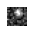

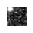

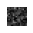

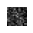

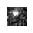

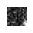

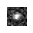

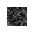

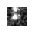

In [11]:
for f in frames:
    plt.figure(figsize=(0.35, 0.35))
    plt.axis("off")
    plt.imshow(model.data[ontarget, f].numpy(),
               vmin=vmin, vmax=vmax, cmap="gray")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-aois-{f}.png", dpi=600)
    plt.show()

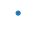

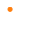

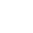

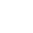

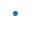

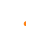

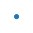

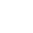

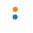

In [12]:
for f in frames:
    fig = plt.figure(figsize=(0.35, 0.35))

    plt.imshow(np.ones((model.data.D, model.data.D)),
               vmin=0, vmax=1, cmap="gray")
    # add patch
    for k in range(2):
        if model.m_probs[k, n, f].item() > 0.5:
            plt.gca().add_patch(
                Circle(
                    (model.data.target_locs[n, f, 1] +
                     pyro.param("d/y_mean")[k, n, f].item(),
                     model.data.target_locs[n, f, 0] +
                     pyro.param("d/x_mean")[k, n, f].item()),
                    1.5, color=f"C{k}"
                )
            )
    plt.axis("off")
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-{f}.png", dpi=600)
    plt.show()

In [13]:
f1, f2 = 275, 296

model.n = torch.tensor([n])
trace = pyro.poutine.trace(model.guide).get_trace()

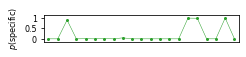

In [14]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_marginal[n, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="on-target"
)
#plt.plot(
#    np.arange(f1, f2),
#    1 - (1 - model.j_probs[:, n, f1:f2]).prod(0),
#    "o-", ms=2, lw=0.5, color="C3", label="off-target"
#)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\mathrm{specific})$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-pspecific.svg")
plt.show()

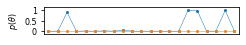

In [15]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.z_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$\theta=1$"
)
plt.plot(
    np.arange(f1, f2),
    model.z_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$\theta=2$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(\theta)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-theta.svg")
plt.show()

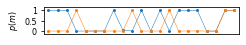

In [16]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    model.m_probs[0, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C0", label=r"$m_{1}$"
)
plt.plot(
    np.arange(f1, f2),
    model.m_probs[1, n, f1:f2],
    "o-", ms=2, lw=0.5, color="C1", label=r"$m_{2}$"
)
plt.xticks([])
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p(m)$", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-m.svg")
plt.show()

In [17]:
sites = [
    "d/height_0",
    "d/height_1",
    "d/width_0",
    "d/width_1",
    "d/x_0",
    "d/x_1",
    "d/y_0",
    "d/y_1",
    "d/background",
]
ci_stats = ci_from_trace(trace, sites)

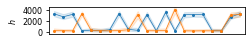

In [18]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["ll"][f1:f2], ci_stats[f"d/height_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/height_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([0, 2000, 4000], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(-500, 4500)
plt.ylabel(r"$h$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-h.svg")
plt.show()

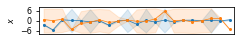

In [19]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$x$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-x.svg")
plt.show()

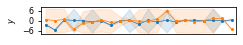

In [20]:
plt.figure(figsize=(3.5,0.5))

for k in range(2):
    plt.fill_between(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["ll"][f1:f2], ci_stats[f"d/x_{k}"]["ul"][f1:f2],
        alpha=0.15, color=f"C{k}"
    )
    plt.plot(
        np.arange(f1, f2),
        ci_stats[f"d/x_{k}"]["mean"][f1:f2],
        "o-", ms=2, lw=0.7, color=f"C{k}",
    )

plt.xticks([])
plt.yticks([-6, 0, 6], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylabel(r"$y$", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-y.svg")
plt.show()

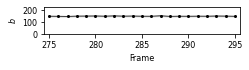

In [21]:
plt.figure(figsize=(3.5,0.5))

plt.plot(
    np.arange(f1, f2),
    ci_stats["d/background"]["mean"][f1:f2],
    "o-", ms=2, lw=0.7, color="k"
)
plt.fill_between(
    np.arange(f1, f2),
    ci_stats["d/background"]["ll"][f1:f2], ci_stats["d/background"]["ul"][f1:f2],
    alpha=0.15, color="k"
)

plt.xticks(np.arange(f1, f2+5, 5), fontsize=8)
plt.yticks([0, 100, 200], fontsize=8)
plt.xlim(f1-0.5, f2-0.5)
plt.ylim(0, 230)
plt.ylabel(r"$b$", fontsize=8)
#plt.legend(fontsize=8)
plt.xlabel("Frame", fontsize=8)

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure3/height-b.svg")
plt.show()

### Figure 4

In [22]:
data_path = EXAMLES_DIR / "height3000"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs4/"
model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

model.n = None
predictive = Predictive(pyro.poutine.uncondition(model.model), guide=model.guide, num_samples=1)
samples = predictive()

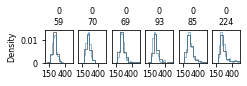

In [23]:
aois = [0, 0, 0, 0, 0, 0]
frames = [59, 70, 69, 93, 85, 224]

plt.figure(figsize=(3.5, 0.6))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.title(f"{n}\n{f}", fontsize=8)
    plt.hist(
        model.data[n, f].flatten().numpy(),
        range=(85, model.data.vmax+150),
        density=True, bins=10, histtype="step", lw=0.5, color="k")
    plt.hist(
        samples["d/data"][0, n, f].flatten().numpy(),
        range=(85, model.data.vmax+150),
        density=True, bins=20, histtype="step", lw=0.5, color="C0")
    plt.xlim(85, model.data.vmax+150)
    plt.xticks([150, 400], fontsize=8)
    if i == 0:
        plt.yticks(fontsize=8)
        plt.ylabel("Density", fontsize=8)
        plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
    else:
        plt.yticks([])

# plt.tight_layout()
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/height-hist.svg")

plt.show()

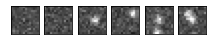

In [24]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    
    plt.imshow(model.data[n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/height-data.png", dpi=600)

plt.show()

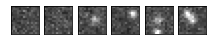

In [25]:
plt.figure(figsize=(3.5, 1))
for i, n, f in zip(np.arange(6), aois, frames):
    plt.subplot(1, 6, i+1)
    plt.imshow(samples["d/data"][0, n, f].numpy(), vmin=120, vmax=model.data.vmax+150, cmap="gray")
    plt.xticks([], [])
    plt.yticks([], [])

# plt.tight_layout()
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure4/height-sample.png", dpi=600)

plt.show()

### Figure 5

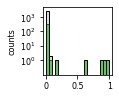

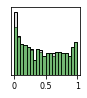

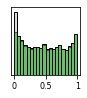

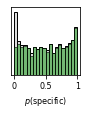

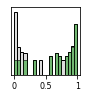

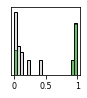

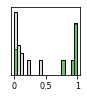

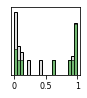

In [26]:
for name in fit_df.index:
    plt.figure(figsize=(1.25, 1.25))
    plt.hist(predictions[name]["z_all"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="#dddddd", edgecolor="k",
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    plt.hist(predictions[name]["z_masked"].numpy(),
             bins=np.arange(0, 1.05, 0.05), histtype="bar", lw=1.,
             color="C2", edgecolor="k", alpha=0.6,
             label=f"{truth_df.loc[name, 'snr']:.2f} SNR")
    plt.yscale("log")
    plt.xlim(-0.05,1.05)
    plt.ylim(1e-1, 5e3)
    plt.xticks([0, 0.5, 1], fontsize=8)
    
    if name == "height300":
        plt.ylabel("counts", fontsize=8)
        plt.yticks([1, 10, 100, 1000], fontsize=8)
    else:
        plt.yticks([])
    if name == "height750":
        plt.xlabel(r"$p(\mathsf{specific})$", fontsize=8)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    # plt.legend(loc="upper center", fontsize=8)
    # plt.savefig(f"/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height{name}.svg")
    plt.show()

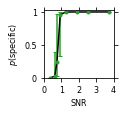

In [27]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.errorbar(truth_df["snr"], fit_df["z_median"],
             yerr=abs(fit_df[["z_ll", "z_ul"]].values.T-fit_df["z_median"].values),
             fmt="o-", ms=3, color="k", mfc="C2", mec="C2", ecolor="C2", capsize=2)
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel("SNR", fontsize=8)
ax.set_ylabel(r"$p(\mathsf{specific})$", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-pspecific.svg")
plt.show()

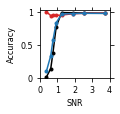

In [28]:
fig, ax = plt.subplots(figsize=(1.25, 1.25))
ax.plot(truth_df["snr"], fit_df["Recall"], "o-", color="k", ms=3, label="Recall")
ax.plot(truth_df["snr"], fit_df["Precision"], "o-", color="C3", ms=3, label="Precision")
ax.plot(truth_df["snr"], fit_df["MCC"], "o-", color="C0", ms=3, label="MCC")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1.03)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis="x", labelsize=8, top=True)
ax.tick_params(axis="y", labelsize=8, right=True)
ax.set_xlabel("SNR", fontsize=8)
ax.set_ylabel("Accuracy", fontsize=8)
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-accuracy.svg")
plt.show()

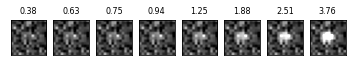

In [29]:
plt.figure(figsize=(6,3))
for i, name in enumerate(truth_df.index):
    plt.subplot(1, len(truth_df), i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{truth_df.loc[name, 'snr']:.2f}", fontsize=8)
    model = Cosmos(1, 2)
    model.load(EXAMLES_DIR / name, False, "cpu")
    plt.imshow(model.data[0, 114].numpy(), vmin=190, vmax=380, cmap="gray")
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure5/height-images.png", dpi=600)
plt.show()